##### [< Forrige](10%20-%20statsmodels.ipynb)     |     [Neste >](12%20-%20animasjon%20med%20klasse.ipynb)

# 11 - interaktive websider

## Gapminder

Vi husker fra sist at vi importerte data fra "gapminder":

In [3]:
import pandas as pd
g = pd.read_csv("https://titlon.uit.no/hht/data/gapminder.csv", index_col=0)#reading data
g

,country,year,population,continent,life_exp,gdp_cap
11,Afghanistan,2007,31889923,Asia,43.828,974.580338
23,Albania,2007,3600523,Europe,76.423,5937.029526
35,Algeria,2007,33333216,Africa,72.301,6223.367465
47,Angola,2007,12420476,Africa,42.731,4797.231267
59,Argentina,2007,40301927,Americas,75.320,12779.379640
...,...,...,...,...,...,...
1655,Vietnam,2007,85262356,Asia,74.249,2441.576404
1667,West Bank and Gaza,2007,4018332,Asia,73.422,3025.349798
1679,"Yemen, Rep.",2007,22211743,Asia,62.698,2280.769906
1691,Zambia,2007,11746035,Africa,42.384,1271.211593


### *Formatering av data*

Vi plottet så dataene, etter å ha konverter BNP til logartime:

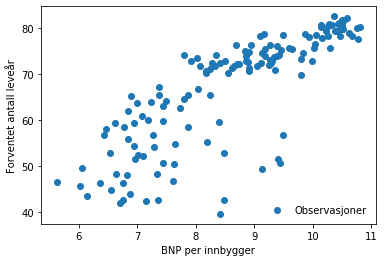

In [4]:
import numpy as np
from matplotlib import pyplot as plt

fig,ax=plt.subplots()

#adding axis lables:
ax.set_ylabel('Forventet antall leveår')
ax.set_xlabel('BNP per innbygger')

#plotting the function:
ax.scatter(np.log(g['gdp_cap']), g['life_exp'],  label='Observasjoner')
ax.legend(loc='lower right',frameon=False)

Vi ønsker imidlertid å lage en litt mer interessant fremstilling enn dette ved å 

1. Oversette navene på verdensdeler fra engelsk til norsk
2. Lage spesielle fargekoder for hver verdensdel
3. La størrelsen på prikkene indikere størrelse på land
3. Skape interaktivitet ved at det popper opp opplysningeer om navn, BNP, levealder og befolkning når man holder pekere over. 


Det første vi må gjøre for å få til det er å lage en datasettet som inneholder de dataene vi trenger for å få til dette. Vi starter med 1. og 2., ved å lage oppslag som definerer norske navn og fargekode. Disse brukes så med pandas `apply`-funksjon til å definere en kolonne `continent_no` med norske navn og en `colors`-kolonne:

In [5]:
#creating a dictionary of continents with norwegian translation:
continents={'Africa': 'Afrika', 'Americas': 'Sør/Nord-Amerika', 'Asia': 'Asia', 'Europe': 'Europa', 'Oceania': 'Oseania'}
#assigning a color hex-code to each continent
colors={'Africa': '#E14827', 'Americas': '#84E127', 'Asia': '#2792E1', 'Europe': '#BC27E1', 'Oceania': '#E04A6C'}


g['continent_no']=g['continent'].apply(lambda cont:  continents[cont])
g['colors']=g['continent'].apply(lambda cont: colors[cont])
g

,country,year,population,continent,life_exp,gdp_cap,continent_no,colors
11,Afghanistan,2007,31889923,Asia,43.828,974.580338,Asia,#2792E1
23,Albania,2007,3600523,Europe,76.423,5937.029526,Europa,#BC27E1
35,Algeria,2007,33333216,Africa,72.301,6223.367465,Afrika,#E14827
47,Angola,2007,12420476,Africa,42.731,4797.231267,Afrika,#E14827
59,Argentina,2007,40301927,Americas,75.320,12779.379640,Sør/Nord-Amerika,#84E127
...,...,...,...,...,...,...,...,...
1655,Vietnam,2007,85262356,Asia,74.249,2441.576404,Asia,#2792E1
1667,West Bank and Gaza,2007,4018332,Asia,73.422,3025.349798,Asia,#2792E1
1679,"Yemen, Rep.",2007,22211743,Asia,62.698,2280.769906,Asia,#2792E1
1691,Zambia,2007,11746035,Africa,42.384,1271.211593,Afrika,#E14827


Punkt 3. var at størrelsen på prikkene skal indikere land. Da trenger vi en kolonne som angir størrelse i pikser, som python forstår, i stedet for faktisk befolkning. Variasjonen i befolkning er også så stor at vi tar roten av den faktiske befolkningen for at det skal se penere ut. Formelen for størrelse på prikkene er derfor `pop**0.5/300`, der `pop`er befolkning i millioner:

In [6]:
g['size']=g['population'].apply(lambda pop: pop**0.5/300)
g[g['country']=='India']

,country,year,population,continent,life_exp,gdp_cap,continent_no,colors,size
707,India,2007,1110396331,Asia,64.698,2452.210407,Asia,#2792E1,111.075366


Til sist definerer vi variablene som skal poppe opp når vi holder pekeren over en prikk. For å få norsk tusenskilletegn, med mellomrom, benytter vi følgende konvertering:

In [7]:
'{:,}'.format(int(23153161365)).replace(',',' ')

'23 153 161 365'

Vi kan nå, med norsk tusenskilletegn, definere BNP i norske kroner (vekslingskurs 8.9NOK/USD), forventet livslengde i heltall og befolkning i millioner, i heltall. 

In [8]:
g['gdp_capNOK']=g['gdp_cap'].apply(lambda gdp: '{:,}'.format(int(8.9*gdp)).replace(',',' '))
g['life_exp_rnd']=g['life_exp'].apply(lambda l: int(l))
g['pop_mill_str']=g['population'].apply(lambda pop:  '{:,}'.format(int(pop/1000000)))
g

,country,year,population,continent,life_exp,gdp_cap,continent_no,colors,size,gdp_capNOK,life_exp_rnd,pop_mill_str
11,Afghanistan,2007,31889923,Asia,43.828,974.580338,Asia,#2792E1,18.823721,8 673,43,31
23,Albania,2007,3600523,Europe,76.423,5937.029526,Europa,#BC27E1,6.325015,52 839,76,3
35,Algeria,2007,33333216,Africa,72.301,6223.367465,Afrika,#E14827,19.244975,55 387,72,33
47,Angola,2007,12420476,Africa,42.731,4797.231267,Afrika,#E14827,11.747565,42 695,42,12
59,Argentina,2007,40301927,Americas,75.320,12779.379640,Sør/Nord-Amerika,#84E127,21.161266,113 736,75,40
...,...,...,...,...,...,...,...,...,...,...,...,...
1655,Vietnam,2007,85262356,Asia,74.249,2441.576404,Asia,#2792E1,30.779206,21 730,74,85
1667,West Bank and Gaza,2007,4018332,Asia,73.422,3025.349798,Asia,#2792E1,6.681926,26 925,73,4
1679,"Yemen, Rep.",2007,22211743,Asia,62.698,2280.769906,Asia,#2792E1,15.709779,20 298,62,22
1691,Zambia,2007,11746035,Africa,42.384,1271.211593,Afrika,#E14827,11.424163,11 313,42,11


### *bokeh*

Vi skal bruke en pakke som heter `bokeh` til å lage en interaktiv figur og nettside, av datasettet vi nettopp laget ferdig. Vi starter med å definere figuren. I Eksempel 13 lager vi en figur ved å kalle på figurfunksjonen i bokeh. 

* De første fire argumentene definerer tittel og navn på aksene. 
* `x_axis_type = "log"` har samme effekt som å konvertere BNP til log i [10 - statsmodels](10%20-%20statsmodels.ipynb), men med den forskjell at det er benevningen på aksen og ikke selve variabelen som konverteres. 
* Så defineres at det skal være en interaktiv graf som skal reagere på at pekeren beveges over, med `tools = "hoover"`.
* Pekeren skal åpne en boks med en liten liste med navn på land, BNP/Innbygger, forventet levealder og Befolkning. Dette oppnås med argumentet `tooltips`. Hvert element i listen er en `tuple` med tekst som skal vises, og hilken kolonne dataene skal hentes fra. For eksempel betyr `("Land","@country")` at på den første linjen skal teksten "Land" vises, og informasjonen skal hentes fra kolonnen "country" i datasettet. 
* Til sist settes størrelsen på plottet


#### Eksempel 13:

In [9]:
from bokeh.plotting import figure

#creating figure:
p = figure(
        title = "Levealder og BNP per innbygger", 
        x_axis_label = 'BNP per innbygger (NOK)',
        y_axis_label = 'Forventet antall leveår',
    
        x_axis_type = "log",
    
        tools="hover", 
        tooltips = [
            ("Land","@country"),
            ("BNP/innbygger","@gdp_capNOK"),
            ("Forventet alder","@life_exp_rnd"),
            ("Befolkning","@pop_mill_str")
            ],
    
        plot_height = 580,
        plot_width = 980)

Vi kan nå definere hva slags plott vi skal ha. Vi skal ha et scatter-plott som i [10 - statsmodels](10%20-%20statsmodels.ipynb), men dette blir altså litt mer fancy. 

In [10]:
from bokeh.io import show, output_notebook

p.scatter(
    source=g,
    
    x= 'gdp_cap', 
    y= 'life_exp', 
    size='size', 
    color= 'colors',
    legend_field='continent_no',
    
    alpha= 0.8
    )

output_notebook()
show(p)

Loading BokehJS ...

I funksjonen `scatter` over angis datasettet med det første argumentet (`source=g`). Etter det angis hvilken kolonne som skal angi henholdsvis x-akse, y-akse, størrelse, farge og etikettnavn. Til sist angis at prikkene skal være 20% gjennomsiktig. 

Etter å ha definert plottet kalles `output_notebook`- òg `show`-funksjonene i `bokeh` for å vise resultatet henholdsvis i jupyter og som en html-fil som åpnes som en fane i nettleseren din.   

In [ ]:
from statsmodels.regression.linear_model import OLS
x=pd.DataFrame(np.log(g['gdp_cap']))
x['intercept']=1
y=g['life_exp']
res=OLS(y,x).fit()

In [4]:
#!/usr/bin/python
# -*- coding: UTF-8 -*-
import pandas as pd
from bokeh.plotting import figure, output_file
from bokeh.io import output_notebook, show


#creating figure:
p = figure(
        title = "", 
        x_axis_type="log",
        x_axis_label='BNP per innbygger (NOK)',
        y_axis_label='Forventet antall leveår',
        tools="hover", 
        tooltips=[
            ("Land","@country"),
            ("BNP/innbygger","@gdp_capNOK"),
            ("Forventet alder","@life_exp_rnd"),
            ("Befolkning","@pop_mill_str")
            ],
        plot_height=580,
        plot_width=980)

#creating a dictionary of continents with norwegian translation:
continents={'Africa': 'Afrika', 'Americas': 'Sør/Nord-Amerika', 'Asia': 'Asia', 'Europe': 'Europa', 'Oceania': 'Oseania'}
#assigning a color hex-code to each continent
colors={'Africa': '#E14827', 'Americas': '#84E127', 'Asia': '#2792E1', 'Europe': '#BC27E1', 'Oceania': '#E04A6C'}

#obtaining and altering the data
g = pd.read_csv("https://titlon.uit.no/hht/data/gapminder.csv", index_col=0)#reading data
g['colors']=g['continent'].apply(lambda cont: colors[cont])
g['size']=g['population'].apply(lambda pop: pop**0.5/300)
g['life_exp_rnd']=g['life_exp'].apply(lambda l: int(l))
g['pop_mill_str']=g['population'].apply(lambda pop:  '{:,}'.format(int(pop/1000000)))
g['gdp_capNOK']=g['gdp_cap'].apply(lambda gdp:  '{:,}'.format(int(8.9*gdp)).replace(',',' '))
g['continent_no']=g['continent'].apply(lambda cont:  continents[cont])

#obtaining a scatterplot:
p.scatter(x = 'gdp_cap', y = 'life_exp', size='size', source=g, color = 'colors', alpha = 0.8,legend_field='continent_no')

show(p)

In [3]:
#x=np.linspace(min(g['gdp_cap']), max(g['gdp_cap']), 100)
#p.line(x, res.params['intercept']+res.params['gdp_cap']*np.log(x),color='red')

#formatting:
p.xaxis.major_label_overrides = { 1000: '1k', 10000: '10k', 100000: '100k' }
p.legend.location = "top_left"
p.legend[0].border_line_alpha=0
p.outline_line_alpha=0
p.grid[0].grid_line_alpha=0
p.grid[1].grid_line_alpha=0

output_file('')
output_file("./BNP_levealder.html")
output_notebook()

show(p)

Loading BokehJS ...

In [ ]:


#defining output:


#drawing it:
show(p)

## Interaktivt kart

Interaktivt kart [som vist her](https://titlon.uit.no/hht/index.php?page=2):

In [ ]:
#!/usr/bin/python
# -*- coding: UTF-8 -*-

#Uncomment next two lines to run in goolge colab
#!pip install geopandas
#!pip install geojson


#importing data used to download files:
import zipfile
import urllib
import requests
import io

#importing the geodata and data packages:
import geopandas as gpd
import geojson
import pandas as pd


#folium is the package that creates the map:
import folium


#file locations:
fp_geodata_url = r"https://titlon.uit.no/hht/data/valgkretser.zip"
fp_coins = r"https://titlon.uit.no/hht/img/coins"
fp_data= r"https://titlon.uit.no/hht/data/valgkretser/data.csv"
fp_geodata=r"Valgkrets.geojson"


def main():
    fp_geodata,data,geodata=get_data()
    create_map(fp_geodata,geodata,data)
    
    
def get_data():
    #loading demographic data:
    data=pd.read_csv(fp_data,encoding="latin-1",delimiter=";")  
    
    #loading the geographical data
    #and converting to a coordinate system that folium understands:
    geodata = gpd.read_file(fp_geodata_url)
    geodata=geodata.to_crs('epsg:4326')    
    
    #pandas does not handle æ, ø å, so creates columns in both the demographic data and geodata that can be matched:
    data['Bydel_dec']=data['Bydel'].apply(lambda s: str(s).encode('ascii','ignore').decode('ascii')) 
    geodata['Bydel_dec']=geodata['VKRETS_V_1'].apply(lambda s: s.encode('ascii','ignore').decode('ascii')) 
    
    #saving the geodata to a geoJSON file for use in the map (folium only eats geoJSON)
    geodata.to_file(fp_geodata, driver='GeoJSON')
    
    #returning the path and variable of the geodata, and the demographic data:
    return fp_geodata,geodata, data

def create_map(fp_geodata,data,geodata):
    #creating the map
    tromso=folium.Map(location=[69.67, 18.98],zoom_start=10)
    
    #adding the colour overlay displaying "redness" of municipalities:
    f=folium.Choropleth(
        geo_data=fp_geodata,
        name="choropleth",
        columns=["Bydel_dec", "Rødhet"],
        data=data,
        key_on="feature.properties.Bydel_dec",
        fill_color="RdBu",
        nan_fill_color='white',
        fill_opacity=0.5,
        legend_name="Valgresultat oppslutning H+Frp minus Ap+SV+Rødt",
    ).add_to(tromso)
    
    folium.LayerControl().add_to(tromso)
    
    #the data needs to be merged on a variable with the same name:
    geodata['Bydel']=geodata['VKRETS_V_1']
    
    #merging the demographic data into the geodata:
    geodata=geodata.merge(data,on='Bydel')
    
    
    for i,r in geodata.iterrows():
        #obtaining coordinates:
        lat=float(r['Lat'])
        lon=float(r['Lon'])   
        
        #creating pin for general demographic data 
        t=(f"<b>{r['Bydel']}</b><br>"
            f"Inntekt: {r['Inntekt']}<br>"
            f"Alder: {frmt_int(r['Alder'])}<br>"
            f"Høyere utdanning: {frmt_int(r['Andel med høyere utdanning'])}%<br>"
            f"Ap+SV+Rødt: {frmt_int(r['ApSVRV']*100)}%<br>"
            f"H+FrP: {frmt_int(r['HFrp']*100)}%")
        folium.Marker([lat,lon-0.01],tooltip=t,icon=folium.Icon(color='red')).add_to(tromso)
        
        #creating pin for wealth. The height of the stack of coins is determined by the 
        #picture file f"./img/{int(r['Mynter'])}coins.png":
        icon=folium.features.CustomIcon(f"{fp_coins}/{int(r['Mynter'])}coins.png")
        folium.Marker([lat,lon+0.01],tooltip=f"Formue:{r['Formue']}",icon=icon).add_to(tromso)
        
    #saving the map as a html file:
    tromso.save('./tromso.html')

def frmt_int(value):
    "This function ensures an error free conversion of value to int"
    try:
        return int(value)
    except:
        return value
        

main()

## Oppgaver:

#### Oppgave 1:

Legg til regresjonslinjen fra [10 - statsmodels](10%20-%20statsmodels.ipynb) i den interaktive grafen 

##### [< Forrige](10%20-%20statsmodels.ipynb)     |     [Neste >](12%20-%20animasjon%20med%20klasse.ipynb)